In [ ]:
%load_ext autoreload
%autoreload 2

import sys
sys.path.append("..")

import os
os.environ['R_HOME'] = 'D:/Program Files/R-4.5.0' #@TODO include in some setup file

from simulation_engine.scenarios.iv.binary_iv import BinaryIV
from simulation_engine.scenarios.conf.binary_conf import BinaryConf
from simulation_engine.scenarios.iv.continuous_iv import ContinuousIV
from simulation_engine.util.plotting_util import PlottingUtil

import pandas as pd
pd.set_option('display.max_columns', None)

#disable warnings
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import matplotlib.pyplot as plt
import seaborn as sns
import math
# from linearmodels.iv import IV2SLS
import statsmodels.api as sm
import statsmodels.formula.api as smf
from sklearn.neural_network import MLPClassifier
# Train a decision tree classifier to predict 'tightest_bounds'
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from simulation_engine.util.plotting_util import PlottingUtil
pd.options.mode.chained_assignment = None  # default='warn'


In [18]:
import re

#setup
results = pd.read_pickle('17_06.pkl')
binaryIV = BinaryIV('IV DAG', results)
ATE_algs = binaryIV.get_algorithms('ATE')
PNS_algs = binaryIV.get_algorithms('PNS')
algs = ATE_algs + PNS_algs
results.columns.tolist()


['seed',
 'intercept_X',
 'intercept_Y',
 'b_U_X',
 'b_X_Y',
 'b_U_Y',
 'ATE_true',
 'PNS_true',
 'p_Y1_mean',
 'p_Y0_mean',
 'p_U',
 'U',
 'X',
 'Y',
 'epsilon_X',
 'sigma_X_vec',
 'epsilon_Y',
 'sigma_Y_vec',
 'entropy_U',
 'entropy_X',
 'entropy_Y',
 'squasher_X_name',
 'squasher_Y_name',
 'heteroskedasticity_structure',
 'ATE_OLS-0.99_bound_lower',
 'ATE_OLS-0.99_bound_upper',
 'ATE_OLS-0.99_bound_valid',
 'ATE_OLS-0.99_bound_width',
 'ATE_OLS-0.99_bound_failed',
 'ATE_OLS-0.98_bound_lower',
 'ATE_OLS-0.98_bound_upper',
 'ATE_OLS-0.98_bound_valid',
 'ATE_OLS-0.98_bound_width',
 'ATE_OLS-0.98_bound_failed',
 'ATE_OLS-0.95_bound_lower',
 'ATE_OLS-0.95_bound_upper',
 'ATE_OLS-0.95_bound_valid',
 'ATE_OLS-0.95_bound_width',
 'ATE_OLS-0.95_bound_failed',
 'ATE_causaloptim_bound_lower',
 'ATE_causaloptim_bound_upper',
 'ATE_causaloptim_bound_valid',
 'ATE_causaloptim_bound_width',
 'ATE_causaloptim_bound_failed',
 'PNS_causaloptim_bound_lower',
 'PNS_causaloptim_bound_upper',
 'PNS_causa

In [ ]:
# remove all cols that cotain 'tianpearl' 
cols_to_remove = [col for col in results.columns if 'tianpearl' in col or 'manski' in col]
results2 = results.drop(columns=cols_to_remove)
results2
scenario = BinaryConf

,seed,intercept_X,intercept_Y,b_U_X,b_X_Y,b_U_Y,ATE_true,PNS_true,p_Y1_mean,p_Y0_mean,p_U,U,X,Y,epsilon_X,sigma_X_vec,epsilon_Y,sigma_Y_vec,entropy_U,entropy_X,entropy_Y,squasher_X_name,squasher_Y_name,heteroskedasticity_structure,ATE_OLS-0.99_bound_lower,ATE_OLS-0.99_bound_upper,ATE_OLS-0.99_bound_valid,ATE_OLS-0.99_bound_width,ATE_OLS-0.99_bound_failed,ATE_OLS-0.98_bound_lower,ATE_OLS-0.98_bound_upper,ATE_OLS-0.98_bound_valid,ATE_OLS-0.98_bound_width,ATE_OLS-0.98_bound_failed,ATE_OLS-0.95_bound_lower,ATE_OLS-0.95_bound_upper,ATE_OLS-0.95_bound_valid,ATE_OLS-0.95_bound_width,ATE_OLS-0.95_bound_failed,ATE_causaloptim_bound_lower,ATE_causaloptim_bound_upper,ATE_causaloptim_bound_valid,ATE_causaloptim_bound_width,ATE_causaloptim_bound_failed,PNS_causaloptim_bound_lower,PNS_causaloptim_bound_upper,PNS_causaloptim_bound_valid,PNS_causaloptim_bound_width,PNS_causaloptim_bound_failed,ATE_autobound_bound_lower,ATE_autobound_bound_upper,ATE_autobound_bound_valid,ATE_autobound_bound_width,ATE_autobound_bound_failed,PNS_autobound_bound_lower,PNS_autobound_bound_upper,PNS_autobound_bound_valid,PNS_autobound_bound_width,PNS_autobound_bound_failed,ATE_entropybounds-0.80_bound_lower,ATE_entropybounds-0.80_bound_upper,ATE_entropybounds-0.80_bound_valid,ATE_entropybounds-0.80_bound_width,ATE_entropybounds-0.80_bound_failed,ATE_entropybounds-0.80_theta,ATE_entropybounds-0.20_bound_lower,ATE_entropybounds-0.20_bound_upper,ATE_entropybounds-0.20_bound_valid,ATE_entropybounds-0.20_bound_width,ATE_entropybounds-0.20_bound_failed,ATE_entropybounds-0.20_theta,ATE_entropybounds-0.10_bound_lower,ATE_entropybounds-0.10_bound_upper,ATE_entropybounds-0.10_bound_valid,ATE_entropybounds-0.10_bound_width,ATE_entropybounds-0.10_bound_failed,ATE_entropybounds-0.10_theta,PNS_entropybounds-0.80_bound_lower,PNS_entropybounds-0.80_bound_upper,PNS_entropybounds-0.80_bound_valid,PNS_entropybounds-0.80_bound_width,PNS_entropybounds-0.80_bound_failed,PNS_entropybounds-0.80_theta,PNS_entropybounds-0.20_bound_lower,PNS_entropybounds-0.20_bound_upper,PNS_entropybounds-0.20_bound_valid,PNS_entropybounds-0.20_bound_width,PNS_entropybounds-0.20_bound_failed,PNS_entropybounds-0.20_theta,PNS_entropybounds-0.10_bound_lower,PNS_entropybounds-0.10_bound_upper,PNS_entropybounds-0.10_bound_valid,PNS_entropybounds-0.10_bound_width,PNS_entropybounds-0.10_bound_failed,PNS_entropybounds-0.10_theta,PNS_entropybounds-trueTheta_bound_lower,PNS_entropybounds-trueTheta_bound_upper,PNS_entropybounds-trueTheta_bound_valid,PNS_entropybounds-trueTheta_bound_width,PNS_entropybounds-trueTheta_bound_failed,PNS_entropybounds-trueTheta_theta,ATE_entropybounds-trueTheta_bound_lower,ATE_entropybounds-trueTheta_bound_upper,ATE_entropybounds-trueTheta_bound_valid,ATE_entropybounds-trueTheta_bound_width,ATE_entropybounds-trueTheta_bound_failed,ATE_entropybounds-trueTheta_theta,PNS_entropybounds-randomTheta_bound_lower,PNS_entropybounds-randomTheta_bound_upper,PNS_entropybounds-randomTheta_bound_valid,PNS_entropybounds-randomTheta_bound_width,PNS_entropybounds-randomTheta_bound_failed,PNS_entropybounds-randomTheta_theta,ATE_entropybounds-randomTheta_bound_lower,ATE_entropybounds-randomTheta_bound_upper,ATE_entropybounds-randomTheta_bound_valid,ATE_entropybounds-randomTheta_bound_width,ATE_entropybounds-randomTheta_bound_failed,ATE_entropybounds-randomTheta_theta,ATE_zaffalonbounds_bound_lower,ATE_zaffalonbounds_bound_upper,ATE_zaffalonbounds_bound_valid,ATE_zaffalonbounds_bound_width,ATE_zaffalonbounds_bound_failed,PNS_zaffalonbounds_bound_lower,PNS_zaffalonbounds_bound_upper,PNS_zaffalonbounds_bound_valid,PNS_zaffalonbounds_bound_width,PNS_zaffalonbounds_bound_failed
0,430991,2.272695,-0.166546,0.513962,-5.000000,0.558918,-0.530607,0.000024,0.004054,0.534661,0.460588,"[0, 0, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, ...","[1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0.04734219331324782, -1.5625569847413805, 0.0...","[0.8607523108252084, 2.9138927

In [5]:
results['entropy_U'].describe()

count    2000.000000
mean        0.684289
std         0.279233
min         0.020814
25%         0.429759
50%         0.733767
75%         0.970951
max         0.999954
Name: entropy_U, dtype: float64

In [ ]:
ate_cols = [col for col in results.columns if col.startswith('ATE_')]
algorithm_names = set()
for col in ate_cols:
    match = re.match(r'ATE_([^_]+)', col)
    if match and match.group(1) != 'true':
        algorithm_names.add('ATE_'+match.group(1))
algorithm_names = sorted(algorithm_names)

                    Algorithm Fail Rate (%) Invalid Rate (%) Net Bound Width Bound Width Invalid Δ (%)
                 ATE_OLS-0.95          0.00            13.40          0.1616      0.4080          1.20
                 ATE_OLS-0.98          0.00             7.70          0.1911      0.3304          1.12
                 ATE_OLS-0.99          0.00             5.05          0.2111      0.3014          1.13
       ATE_entropybounds-0.10          0.00            20.50          0.6464      0.9239          4.88
           ATE_zaffalonbounds          0.00             4.05          0.6609      0.7152          1.04
       ATE_entropybounds-0.20          0.00            10.00          0.8115      0.9304          4.27
ATE_entropybounds-randomTheta          0.00            10.50          0.9049      1.0199          5.21
  ATE_entropybounds-trueTheta          0.00             7.75          0.9565      1.0373          4.86
       ATE_entropybounds-0.80          0.00             6.80          0.9

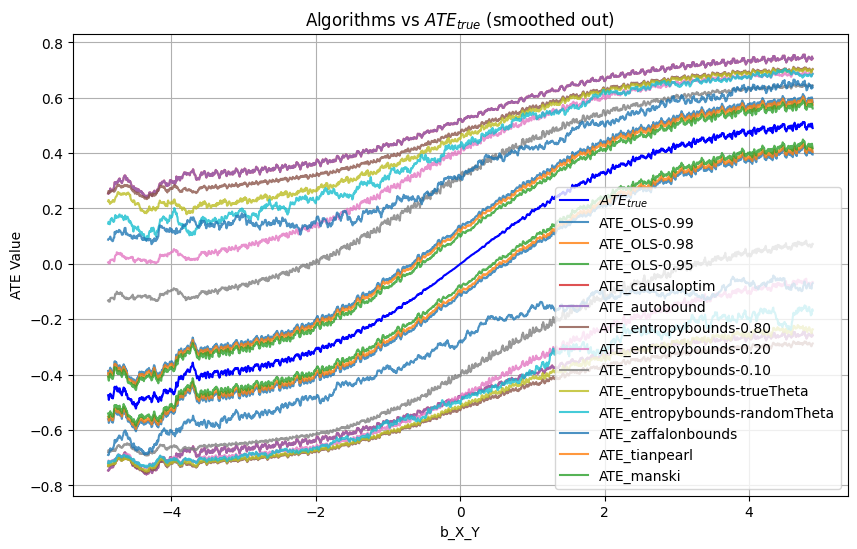

In [7]:
#ATE Evaluation
# Extract unique algorithm names from columns like 'ATE_{algorithm_name}_{...}'
algorithm_names = PlottingUtil.extract_algorithm_names(results, 'ATE')
PlottingUtil.print_bound_statistics_table(results, algorithm_names)
PlottingUtil.plot_smoothed_query_vs_bounds(results, 'ATE', algorithm_names, 50)

In [24]:
# results['PNS_true','PNS_tianpearl_bound_lower', 'PNS_tianpearl_bound_upper']
results

,seed,intercept_X,intercept_Y,b_U_X,b_X_Y,b_U_Y,ATE_true,PNS_true,p_Y1_mean,p_Y0_mean,p_U,U,X,Y,epsilon_X,sigma_X_vec,epsilon_Y,sigma_Y_vec,entropy_U,entropy_X,entropy_Y,squasher_X_name,squasher_Y_name,heteroskedasticity_structure,ATE_OLS-0.99_bound_lower,ATE_OLS-0.99_bound_upper,ATE_OLS-0.99_bound_valid,ATE_OLS-0.99_bound_width,ATE_OLS-0.99_bound_failed,ATE_OLS-0.98_bound_lower,ATE_OLS-0.98_bound_upper,ATE_OLS-0.98_bound_valid,ATE_OLS-0.98_bound_width,ATE_OLS-0.98_bound_failed,ATE_OLS-0.95_bound_lower,ATE_OLS-0.95_bound_upper,ATE_OLS-0.95_bound_valid,ATE_OLS-0.95_bound_width,ATE_OLS-0.95_bound_failed,ATE_causaloptim_bound_lower,ATE_causaloptim_bound_upper,ATE_causaloptim_bound_valid,ATE_causaloptim_bound_width,ATE_causaloptim_bound_failed,PNS_causaloptim_bound_lower,PNS_causaloptim_bound_upper,PNS_causaloptim_bound_valid,PNS_causaloptim_bound_width,PNS_causaloptim_bound_failed,ATE_autobound_bound_lower,ATE_autobound_bound_upper,ATE_autobound_bound_valid,ATE_autobound_bound_width,ATE_autobound_bound_failed,PNS_autobound_bound_lower,PNS_autobound_bound_upper,PNS_autobound_bound_valid,PNS_autobound_bound_width,PNS_autobound_bound_failed,ATE_entropybounds-0.80_bound_lower,ATE_entropybounds-0.80_bound_upper,ATE_entropybounds-0.80_bound_valid,ATE_entropybounds-0.80_bound_width,ATE_entropybounds-0.80_bound_failed,ATE_entropybounds-0.80_theta,ATE_entropybounds-0.20_bound_lower,ATE_entropybounds-0.20_bound_upper,ATE_entropybounds-0.20_bound_valid,ATE_entropybounds-0.20_bound_width,ATE_entropybounds-0.20_bound_failed,ATE_entropybounds-0.20_theta,ATE_entropybounds-0.10_bound_lower,ATE_entropybounds-0.10_bound_upper,ATE_entropybounds-0.10_bound_valid,ATE_entropybounds-0.10_bound_width,ATE_entropybounds-0.10_bound_failed,ATE_entropybounds-0.10_theta,PNS_entropybounds-0.80_bound_lower,PNS_entropybounds-0.80_bound_upper,PNS_entropybounds-0.80_bound_valid,PNS_entropybounds-0.80_bound_width,PNS_entropybounds-0.80_bound_failed,PNS_entropybounds-0.80_theta,PNS_entropybounds-0.20_bound_lower,PNS_entropybounds-0.20_bound_upper,PNS_entropybounds-0.20_bound_valid,PNS_entropybounds-0.20_bound_width,PNS_entropybounds-0.20_bound_failed,PNS_entropybounds-0.20_theta,PNS_entropybounds-0.10_bound_lower,PNS_entropybounds-0.10_bound_upper,PNS_entropybounds-0.10_bound_valid,PNS_entropybounds-0.10_bound_width,PNS_entropybounds-0.10_bound_failed,PNS_entropybounds-0.10_theta,PNS_entropybounds-trueTheta_bound_lower,PNS_entropybounds-trueTheta_bound_upper,PNS_entropybounds-trueTheta_bound_valid,PNS_entropybounds-trueTheta_bound_width,PNS_entropybounds-trueTheta_bound_failed,PNS_entropybounds-trueTheta_theta,ATE_entropybounds-trueTheta_bound_lower,ATE_entropybounds-trueTheta_bound_upper,ATE_entropybounds-trueTheta_bound_valid,ATE_entropybounds-trueTheta_bound_width,ATE_entropybounds-trueTheta_bound_failed,ATE_entropybounds-trueTheta_theta,PNS_entropybounds-randomTheta_bound_lower,PNS_entropybounds-randomTheta_bound_upper,PNS_entropybounds-randomTheta_bound_valid,PNS_entropybounds-randomTheta_bound_width,PNS_entropybounds-randomTheta_bound_failed,PNS_entropybounds-randomTheta_theta,ATE_entropybounds-randomTheta_bound_lower,ATE_entropybounds-randomTheta_bound_upper,ATE_entropybounds-randomTheta_bound_valid,ATE_entropybounds-randomTheta_bound_width,ATE_entropybounds-randomTheta_bound_failed,ATE_entropybounds-randomTheta_theta,ATE_zaffalonbounds_bound_lower,ATE_zaffalonbounds_bound_upper,ATE_zaffalonbounds_bound_valid,ATE_zaffalonbounds_bound_width,ATE_zaffalonbounds_bound_failed,PNS_zaffalonbounds_bound_lower,PNS_zaffalonbounds_bound_upper,PNS_zaffalonbounds_bound_valid,PNS_zaffalonbounds_bound_width,PNS_zaffalonbounds_bound_failed,ATE_tianpearl_bound_lower,ATE_tianpearl_bound_upper,ATE_tianpearl_bound_width,ATE_tianpearl_bound_failed,ATE_tianpearl_bound_valid,PNS_tianpearl_bound_lower,PNS_tianpearl_bound_upper,PNS_tianpearl_bound_width,PNS_tianpearl_bound_failed,PNS_tianpearl_bound_valid,ATE_manski_bound_lower,ATE_manski_bound_upper,ATE_manski_bound_width,ATE_manski

                    Algorithm Fail Rate (%) Invalid Rate (%) Net Bound Width Bound Width Invalid Δ (%)
                PNS_tianpearl          0.00            99.95          0.0021      0.0021          0.00
           PNS_zaffalonbounds          0.00             0.80          0.4815      0.4857          0.04
       PNS_entropybounds-0.10          0.00             0.05          0.4987      0.4989          0.00
              PNS_causaloptim          0.00             0.00          0.5163      0.5163           N/A
                PNS_autobound          0.00             0.00          0.5163      0.5163           N/A
       PNS_entropybounds-0.20          0.00             0.00          0.5757      0.5757           N/A
PNS_entropybounds-randomTheta          0.00             0.10          0.6427      0.6430          0.77
  PNS_entropybounds-trueTheta          0.00             0.00          0.6875      0.6875           N/A
       PNS_entropybounds-0.80          0.00             0.00          0.7

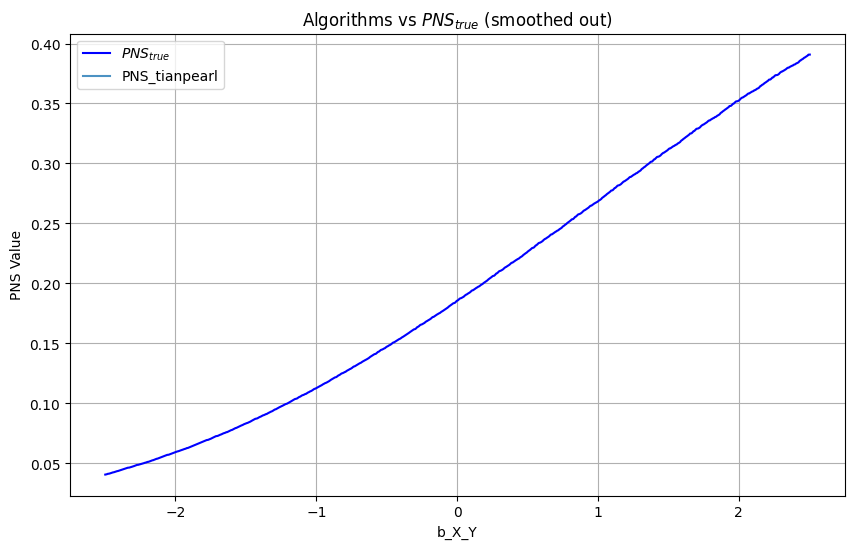

In [15]:
#PNS Evaluation
algorithm_names = PlottingUtil.extract_algorithm_names(results, 'PNS')
PlottingUtil.print_bound_statistics_table(results, algorithm_names, 'PNS')
PlottingUtil.plot_smoothed_query_vs_bounds(results, 'PNS', ['PNS_tianpearl'], 1000)

ATE algorithms: ['2SLS-0.99', '2SLS-0.98', 'causaloptim', 'autobound', 'entropybounds-0.80', 'entropybounds-0.20', 'entropybounds-0.10', 'zaffalonbounds', 'nonpara']
PNS algorithms: ['causaloptim', 'autobound', 'entropybounds-0.80', 'entropybounds-0.20', 'entropybounds-0.10', 'zaffalonbounds', 'nonpara']
PNS algorithms: ['causaloptim', 'autobound', 'entropybounds-0.80', 'entropybounds-0.20', 'entropybounds-0.10', 'zaffalonbounds', 'nonpara']


d:\TUM Workspace\Thesis Workspace\causal-bounds\binaryIV\..\simulation_engine\util\plotting_util.py:233: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(counts.index, rotation=45, ha='right')


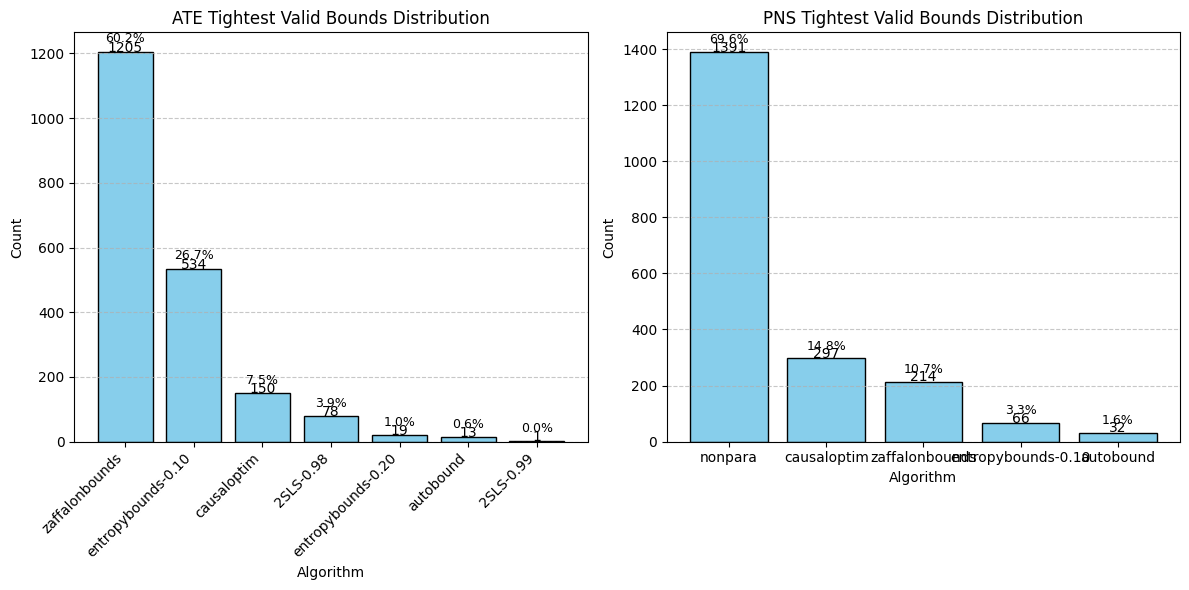

In [38]:
df = results.copy()
# Find tightest bounds without requiring bounds to be valid
tb = PlottingUtil.compute_tightest_bound_valid(df)
PlottingUtil.plot_tightest_bounds_distribution(tb, 'true')
